# CASA0013: Foundations of Spatial Data Science

## Opportunity for cultural tourism in London through Airbnb

### 21203853

# Reproducible Analysis

In [1]:
# Libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os
from matplotlib.colors import ListedColormap
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [2]:
# Initialise the Scalers and Transformers
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(-1,1))
pts = PowerTransformer()

In [3]:
# Reading in ethinicity data file without header to avoid duplicate columns being renamed automatically
url_eth = "https://raw.githubusercontent.com/kav-sekar/fsds_data_brief/main/clean_data/ethinicity_data_by_msoa.csv"
dfEth = pd.read_csv(url_eth, header = None, low_memory=False)

# Assigining top row as head
new_header = dfEth.iloc[0] #grab the first row
dfEth = dfEth[1: ] #take the data less the header row
dfEth.columns = new_header #set the header row as the df header

In [4]:
# Selecting london data based on MSOA code
url_ldnData = "https://raw.githubusercontent.com/kav-sekar/fsds_data_brief/main/clean_data/msoa-data-london.csv"
ldnData = pd.read_csv(url_ldnData, low_memory=False)
dfLnd = pd.merge (dfEth, ldnData, how='right',on=["MSOA Code","MSOA Name"])
dfLnd.dropna(axis = 0, inplace = True)

# Combining duplicate column data as a sum
dfLndComb = dfLnd.groupby(dfLnd.columns, axis=1).agg(np.max)

In [5]:
# Cleaning ethinicity dataframe
dfLndComb.drop(columns=["date","Rural Urban"],inplace = True)#removing date column

# Cleaning column names
dfLndComb.columns = dfLndComb.columns.str.replace(' ', '_') #replacing spcae with underscore
dfLndComb.columns = dfLndComb.columns.str.replace('/', '_') #replacing spcae with underscore

# Arranging columns
dfEthA = dfLndComb[['MSOA_Code','MSOA_Name','All','White']]
dfEthB = dfLndComb[dfLndComb.columns.drop(dfEthA.columns.tolist())]
dfEthComb = pd.concat([dfEthA, dfEthB], axis=1, join="outer")

In [6]:
# Rescaling ethinicity data (inter-Quartile Standardisation)
cList = dfEthComb.columns.tolist()
dfResc = dfEthComb[cList[2:]].copy() #new dataframe to rescale and converting all count to int
cols = dfResc.columns.tolist() #creating list of columns to be rescaled

scalers = [rbs.fit(dfResc[x].values.reshape(-1,1)) #array of scaled values
           for x in cols] #loop rescaling values between 0 to 1 and fitting data

dfResc2 = dfResc.copy()
for i in range(0, len(cols)):
    dfResc2[cols[i]] = rbs.transform(dfResc[cols[i]].values.reshape(-1,1)) #loop for transforming array to dataframe structure

dfStan2 = pd.concat([dfEthComb[['MSOA_Code','MSOA_Name']], dfResc2], axis=1, join="outer") #final rescaled ethinicity data

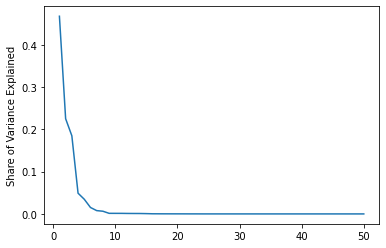

Component  0 accounts for 46.74% of variance
Component  1 accounts for 22.51% of variance
Component  2 accounts for 18.48% of variance
Component  3 accounts for 4.90% of variance
Component  4 accounts for 3.47% of variance
Component  5 accounts for 1.52% of variance
Component  6 accounts for 0.78% of variance
Component  7 accounts for 0.64% of variance
Component  8 accounts for 0.14% of variance
Component  9 accounts for 0.13% of variance
Component 10 accounts for 0.13% of variance
Component 11 accounts for 0.11% of variance
Component 12 accounts for 0.10% of variance
Component 13 accounts for 0.10% of variance
Component 14 accounts for 0.07% of variance
Component 15 accounts for 0.03% of variance
Component 16 accounts for 0.03% of variance
Component 17 accounts for 0.02% of variance
Component 18 accounts for 0.02% of variance
Component 19 accounts for 0.02% of variance


In [7]:
# Principle Component Analysis (PCA) to reduce variables
pca = PCA(n_components=50, whiten=True) #setting up PCA
dfRed = dfResc2.drop(['All', 'White'], axis = 1) #variables to use for PCA (removing 'white' and 'all' as they will not contribute to minority ethinicity analysis to be done using PCA results)
pca.fit(dfRed)

explained_variance = pca.explained_variance_ratio_
singular_values = pca.singular_values_

# Plotting components' explained variance elbow plot
x = np.arange(1,len(explained_variance)+1)
plt.plot(x, explained_variance)
plt.ylabel('Share of Variance Explained')
plt.show()

for i in range(0, 20):
    print(f"Component {i:>2} accounts for {explained_variance[i]*100:>2.2f}% of variance")

In [8]:
# Selecting top 3 PCA components
keep_n_components = 3 #components to keep
pca = PCA(n_components=keep_n_components, whiten=True) #setting up PCA for top 10 components
dfRed_pca = pca.fit_transform(dfRed)

dfRed_pca = dfRed_pca.T #transforming array to match ethinicity dataframe structure
mEthPca = pd.DataFrame()
for i in range (0, keep_n_components): #creating minority ethinicity components dataframe from array
    mEthPca[f"Component_{i+1}"] = dfRed_pca[i]
mEthPca = pd.concat([dfEthA['MSOA_Code'], mEthPca], axis=1, join="outer") #minority ethinicity components

In [9]:
# Load the MSOA GeoData
url_msoas = "https://github.com/kav-sekar/fsds_data_brief/blob/main/clean_data/London_MSOAs.gpkg?raw=true"
msoas = gpd.read_file(url_msoas, driver='GPKG')
msoas = msoas.drop(columns=['OBJECTID','MSOA11NM','BNG_E','BNG_N','Borough','msoa11hclnm'])

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


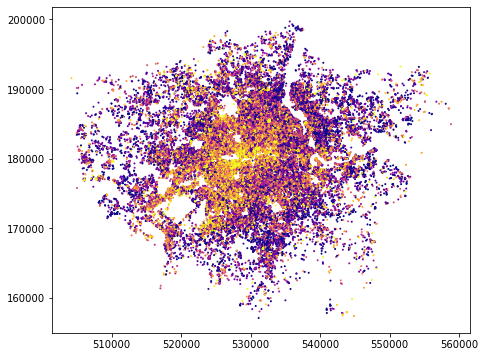

In [10]:
# Load airbnb listing data july 2021 (cleaned to reduce size)
url_listings = "https://raw.githubusercontent.com/kav-sekar/fsds_data_brief/main/clean_data/listings_clean.csv"
dfBnb = pd.read_csv(url_listings,low_memory=False)
dfBnb['price'] = dfBnb.price.str.replace(',','').astype(float)
dfBnb.drop(dfBnb[((dfBnb.latitude.isna())|(dfBnb.longitude.isna()))].index, axis=0, inplace=True)
dfBnb.drop(dfBnb[((dfBnb.latitude < 40)|(dfBnb.longitude > 1))].index, axis=0, inplace=True)

# Creating geodata frame with airbnb listings
gdf = gpd.GeoDataFrame(dfBnb, 
      geometry=gpd.points_from_xy(dfBnb['longitude'], dfBnb['latitude'], crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')
gdf.plot(column='price', cmap='plasma', scheme='quantiles', k=10, markersize=1, figsize=(8,6));

In [11]:
# Aggregate Listings by MSOA
ml = gpd.sjoin(gdf, msoas, op='within').drop(columns=
    ['latitude','longitude','index_right'])
ml[['price','availability_30','availability_60','availability_90','availability_365','review_scores_rating']].astype(float)

# Grouping by msoa and deriving listings price median ane mean avaliibility by MSOA
mlgp = ml.groupby(['MSOA11CD']).agg({'price':'median', 'availability_365':'mean', 'review_scores_rating':'median'}).reset_index() # msoa listings grouped

In [12]:
# Merge the PCA reducded dimensionality minority ethinicity dataframe with the msoa listings grouped data frame
cldfM = pd.merge(mEthPca, mlgp, left_on="MSOA_Code", right_on="MSOA11CD",how="inner")
cldfM = pd.merge(cldfM, msoas, left_on="MSOA11CD", right_on="MSOA11CD",how="inner")
cldfM = cldfM.drop(columns = "MSOA11CD",)
cldfM = cldfM.set_geometry('geometry')

# Range Normalisation of minority ethinicity components (0-1)
cols = ["Component_1","Component_2","Component_3"] #creating list of columns to be rescaled

scalers = [MinMaxScaler(feature_range=(0, 1)).
           fit(cldfM[x].values.reshape(-1,1)) 
           for x in cols] #loop rescaling values between 0 to 1 and fitting data

for i in range(0, len(cols)):
    cldfM[cols[i]] = scalers[i].transform(cldfM[cols[i]].values.reshape(-1,1)) #loop for transforming

In [13]:
# Merge white ethinicity data with the msoa listings grouped data frame
cldfW = pd.merge(dfStan2[["MSOA_Code","White"]], mlgp, left_on="MSOA_Code", right_on="MSOA11CD",how="inner")
cldfW = pd.merge(cldfW, msoas, left_on="MSOA11CD", right_on="MSOA11CD",how="inner")
cldfW = cldfW.drop(columns = "MSOA11CD",)
cldfW = cldfW.set_geometry('geometry')

# Range Normalisation of white ethinicity
cols = ["White"] #creating list of columns to be rescaled

scalers = [MinMaxScaler(feature_range=(0, 1)).
           fit(cldfW[x].values.reshape(-1,1)) 
           for x in cols] #loop rescaling values between 0 to 1 and fitting data

for i in range(0, len(cols)):
    cldfW[cols[i]] = scalers[i].transform(cldfW[cols[i]].values.reshape(-1,1)) #loop for transforming

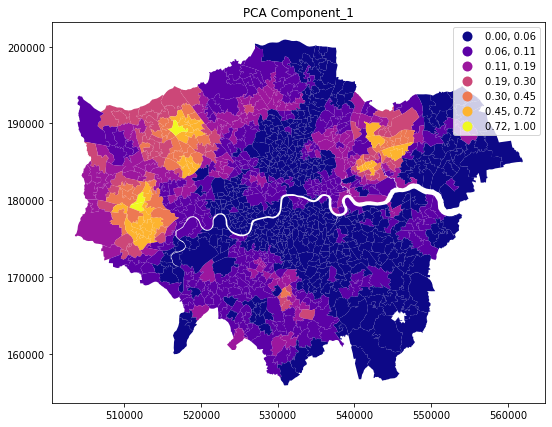

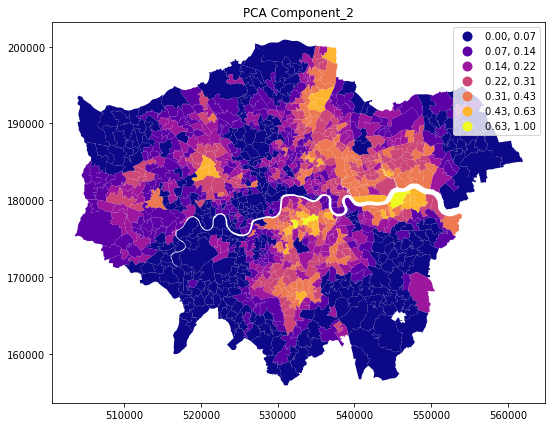

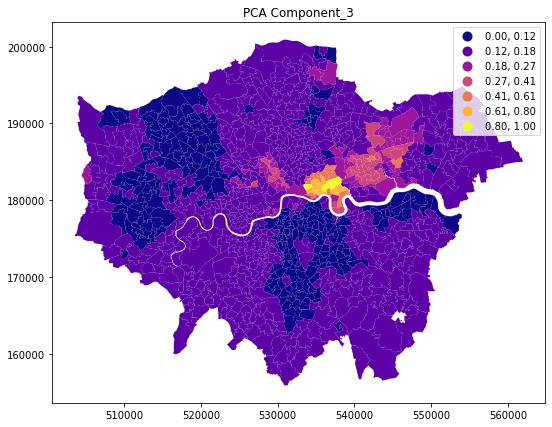

In [14]:
# Plotting minority ethinicity components by msoa

for i in range(1,keep_n_components+1):
    ax = cldfM.plot(column= f'Component_{i}', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(9,7));
    ax.set_title(f'PCA Component_{i}')

Text(0.5, 1.0, 'White')

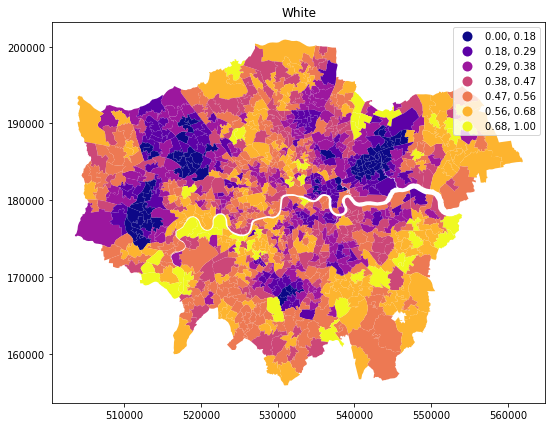

In [15]:
# Plotting white ethinicity by msoa
ax = cldfW.plot(column= 'White', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(9,7));
ax.set_title(f'White')

Text(0.5, 1.0, 'price')

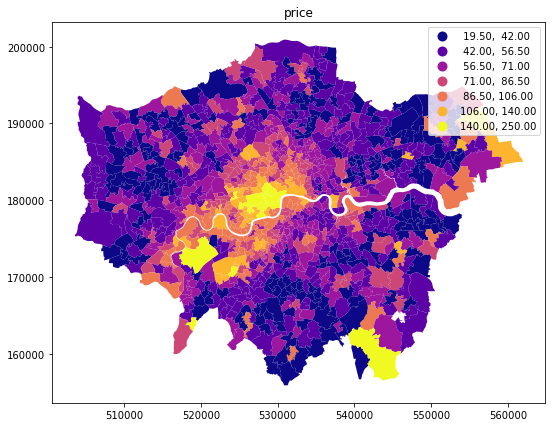

In [16]:
# Plotting median listing price by msoa
ax = cldfM.plot(column= f'price', cmap='plasma', scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(9,7));
ax.set_title(f'price')

<AxesSubplot:xlabel='Component_1', ylabel='price'>

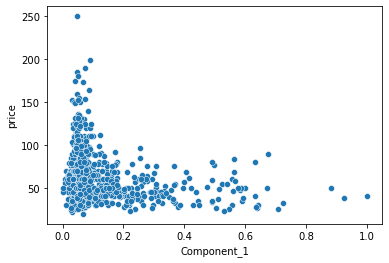

In [17]:
# Plotting minority ethinicity component 1 vs median price (inverse relationship)
sns.scatterplot(data=cldfM, x="Component_1", y="price")

<AxesSubplot:xlabel='Component_2', ylabel='price'>

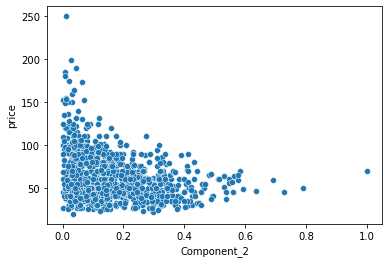

In [18]:
# Plotting minority ethinicity component 2 vs median price (inverse relationship)
sns.scatterplot(data=cldfM, x="Component_2", y="price")

<AxesSubplot:xlabel='Component_3', ylabel='price'>

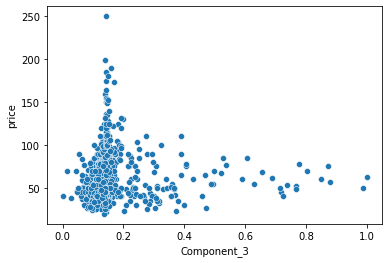

In [19]:
# Plotting minority ethinicity component 3 vs median price (inverse relationship)
sns.scatterplot(data=cldfM, x="Component_3", y="price")

<AxesSubplot:xlabel='White', ylabel='price'>

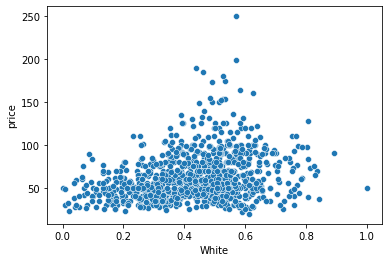

In [20]:
# Plotting white ethinicity vs median price (direct relationship)
sns.scatterplot(data=cldfW, x="White", y="price")

Text(0.5, 1.0, 'Cumulative value fitness criterion')

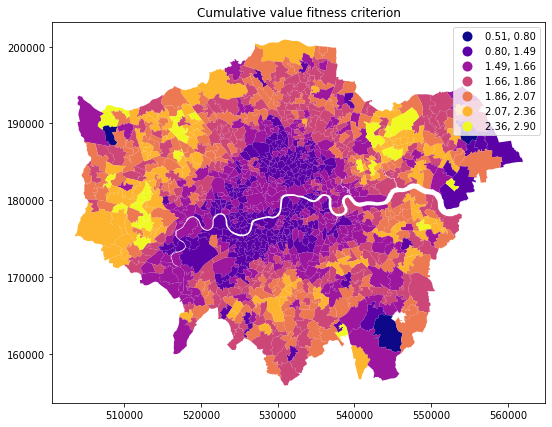

In [21]:
# Heat map of high potential for improvement msoas
# i.e. have high ethnic minority, high rating, low price and high availibility (fitness criterion)
cols = ['Component_1','Component_2','Component_3','availability_365','price','review_scores_rating'] #creating list of columns to be rescaled
dfHi = cldfM[cols].copy().astype(float) 
dfHi['price_inverse'] = 1/dfHi['price'] #inverse of price based on establised relation between price and ethnic minority numbers
dfHi['Min_eth_comp_sum'] = dfHi.iloc[:,0:1].sum(axis=1) #sum of selected ethnic minority components
dfHi = dfHi.drop(['price','Component_1','Component_2','Component_3'], axis=1)
cols = dfHi.columns.values.tolist()

scalers = [MinMaxScaler(feature_range=(0, 1)). #rescaling variables so as to avoid weighting of large scale variables
           fit(dfHi[x].values.reshape(-1,1)) 
           for x in cols] #loop rescaling values between 0 to 1 and fitting data

for i in range(0, len(cols)):
    dfHi[cols[i]] = scalers[i].transform(dfHi[cols[i]].values.reshape(-1,1)) #loop for transforming
    
dfHi['Potential'] = dfHi.sum(axis=1) #single variable representing potential msoas with high ethnic minority, high rating, low price and high availibility
dfHi = pd.concat([cldfM[['geometry','MSOA_Code']], dfHi], axis=1, join="outer")

ax = dfHi.plot(column= 'Potential', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(9,7));
ax.set_title(f'Cumulative value fitness criterion')
#plt.savefig('potential_heatmap.png',  bbox_inches='tight')

Text(0.5, 1.0, 'Cumulative value of minority ethinicity components')

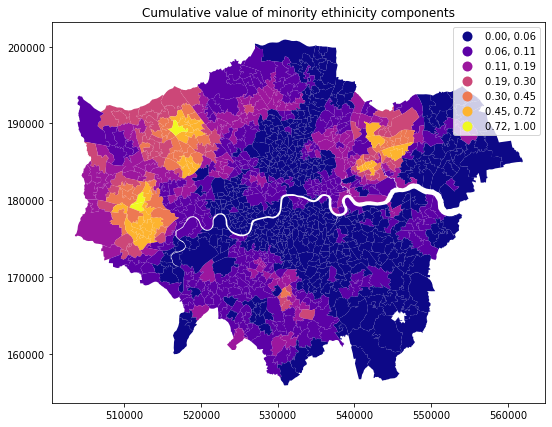

In [22]:
# Plotting minority ethinicity component by msoa
ax = dfHi.plot(column= 'Min_eth_comp_sum', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(9,7));
ax.set_title(f'Cumulative value of minority ethinicity components')

.......................................
Largest silhouette score was 0.5947 for k=2


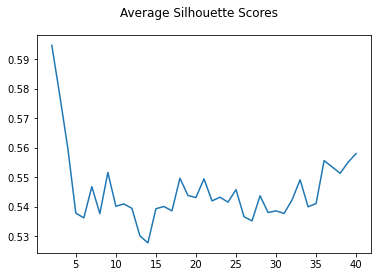

In [23]:
# K-mean clustering based on Potential
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
dfHiK = dfHi.drop(['geometry','MSOA_Code','availability_365',
                   'price_inverse','review_scores_rating','Min_eth_comp_sum'], axis = 1).astype(float) #dataframe for clustering
dfHiK = dfHiK.dropna(axis = 0)

# Finding highest silhoutte score
from sklearn.metrics import silhouette_samples, silhouette_score
x = []
y = []

for k in range(2,41):
    
    #############
    # Do the clustering using the main columns
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(dfHiK)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(dfHiK, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

plt.plot(y, x)
plt.gcf().suptitle("Average Silhouette Scores");

[0 2 1 1 2 1 0 2 2 2 2 0 1 0 2 2 2 1 2 2 2 2 2 0 2 0 2 2 2 1 2 1 1 2 2 2 1
 2 2 2 2 2 0 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2 2 2 2 2 2 2 1 1 2 2 2 1 1 2 2 1
 1 0 1 1 1 0 1 2 2 0 0 2 1 2 2 1 1 1 1 2 1 1 2 1 1 1 2 2 2 2 1 2 2 2 1 2 1
 1 2 2 0 2 2 2 0 0 1 0 0 0 0 0 2 2 0 0 2 0 2 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 2 2 0 2 0 0 0 2 1 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 2 1 2 1 2 2 1 1 1 1 2 2 1 1 2 1 2 0 2 2 2 2 2 2 2 1 2 0 2
 1 2 2 2 2 2 2 0 2 2 1 2 1 2 2 2 2 1 1 2 2 2 1 2 2 0 1 2 2 1 2 2 2 2 2 1 0
 2 1 2 2 1 0 0 2 2 0 0 1 1 0 0 2 1 2 1 2 2 0 2 0 2 2 2 2 2 2 2 2 1 2 2 2 2
 1 2 0 2 2 2 2 2 2 2 2 2 2 2 1 2 2 0 2 2 2 2 2 2 2 0 2 0 2 0 2 0 0 1 2 0 0
 2 0 2 2 2 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 0 2 1 2
 0 0 2 2 0 2 0 0 0 0 0 0 2 2 0 0 0 0 0 2 0 0 0 0 0 2 1 1 2 1 1 1 1 1 1 2 2
 1 1 2 1 2 2 2 1 1 1 1 2 1 2 1 1 1 1 0 2 2 1 2 2 2 2 2 0 2 2 2 1 0 2 2 0 0
 0 2 0 2 2 2 1 0 0 0 1 1 

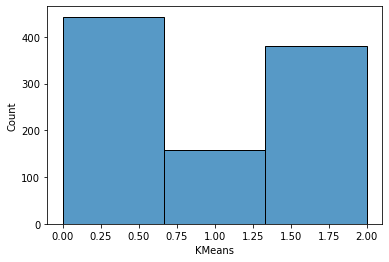

In [24]:
# K-means clustering using highest silhoutte scoring cluster numbers (3 in this case since 2 clusters are insignificant for the analysis)
c_nm   = 'KMeans' # Clustering name
k_pref = 3 # Number of clusters
kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(dfHiK) # The process

print(kmeans.labels_) # The results

# Adding cluster number of each msoa to dataframe
dfHi[c_nm] = pd.Series(kmeans.labels_, index=dfHiK.index)

# Plotting cluster distribution
ax = sns.histplot(data=dfHi, x=c_nm, bins=k_pref);

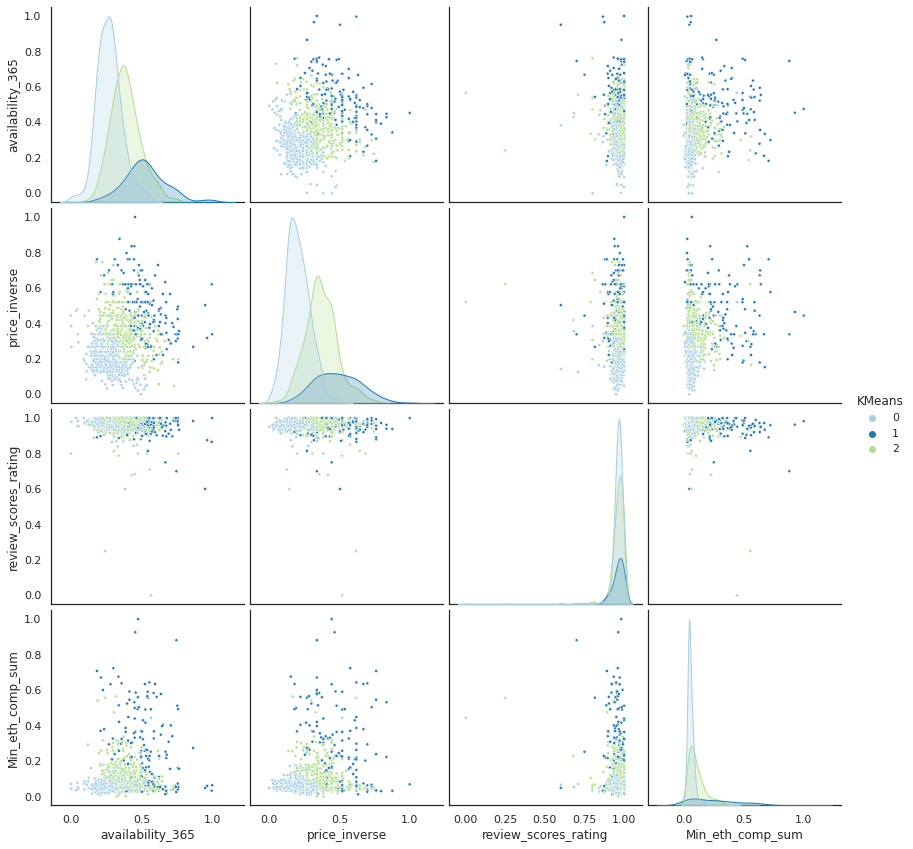

In [25]:
# Plotting cluster distribution against fitness criterion 
# to see performance of each cluster for the specific criteria
sns.set(style="white")
sns.pairplot(dfHi, 
             vars=['availability_365','price_inverse','review_scores_rating','Min_eth_comp_sum'], 
             hue=c_nm, markers=".", height=3, diag_kind='kde', palette="Paired");

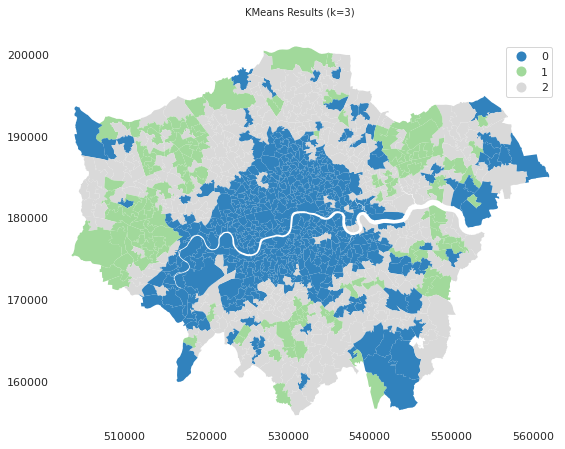

In [26]:
# Mapping the clusters on the London msoas 
# to then select cluster of msoas with best performance for the fitness criteria (i.e. high potental listings)
# and impliment clutural tourism (pilot trial) 
# as an additional service in the airbnb listings in these msoas

fig, ax = plt.subplots(1, figsize=(9,7))
msoas.plot(ax=ax, edgecolor='#ffffff', facecolor='None', zorder=0)
ax.set_xlim([502000,563000])
ax.set_ylim([155000,201500])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=10, y=0.95)
dfHi.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True, cmap='tab20c');
#plt.savefig('map_cluster.png',  bbox_inches='tight')